### Analysis on the Extracted NLA dataset

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

### Information about the Units

In [25]:
file_path = 'Data/Extracted NLA data declassified v2.xlsx'
unit_info_df = pd.read_excel(file_path, sheet_name="unit_table")
unit_info_df

,Unit,YDF ROC,Vendor
0,NL0,4.8cm,NL
1,NL1,4.8cm,NL
2,NL2,4.9cm,NL
3,NL3,4cm,NF
4,NL4,4.9cm,NL
5,NL5,4.8cm,NL
6,NL6,4.7cm,NaN
7,NL7,4.7cm,NL
8,NL8,4cm,NF
9,NL9,4.8cm,NL


From initial inspection, it seems that LUs made from vendor `NL`(ranging 4.7cm-4.9cm) tend to have a larger YDF ROC than those of vendor `NF`(4cm).

With that, we will be tagging Vendor of NL6 which is NaN at the moment, to be `NL`

In [26]:
unit_info_df.loc[unit_info_df["Unit"] == "NL6", "Vendor"] = "NL"
unit_info_df

,Unit,YDF ROC,Vendor
0,NL0,4.8cm,NL
1,NL1,4.8cm,NL
2,NL2,4.9cm,NL
3,NL3,4cm,NF
4,NL4,4.9cm,NL
5,NL5,4.8cm,NL
6,NL6,4.7cm,NL
7,NL7,4.7cm,NL
8,NL8,4cm,NF
9,NL9,4.8cm,NL


### Information about the dataset

In [27]:
unit_df = pd.read_excel(file_path, sheet_name="merged_table")
unit_df

,prod_id,I /A,TFB,LD9 base/oC,CPS Top (mon card),PD1/V,PD2/V
0,NL1,seed on,NaN,NaN,NaN,0.02,0.00
1,NL1,Pramp1 On,25.00,25.50,20.71,5.02,0.00
2,NL1,PreAMP2 on,25.00,25.50,21.65,9.99,0.00
3,NL1,1,25.75,25.75,22.12,9.99,0.01
4,NL1,2,26.25,25.75,24.00,9.99,0.09
...,...,...,...,...,...,...,...
188,NL16,6,28.50,26.25,26.35,9.99,1.22
189,NL16,8,29.75,26.50,28.24,9.99,2.31
190,NL16,10,31.00,26.75,29.65,9.99,3.81
191,NL16,11,31.50,27.00,31.06,9.99,4.19


We can see that some of the `TFB`, `LD9 base/oC`, `CPS Top (mon card)` values for when `I /A` is set as `seed on`, `Pramp1 On` is missing, hence we will use attempt to fill the values using the closest units' values based of closeness of `PD1/V` values to mimic the behaviour.

First, we will need to know which unit's `TFB`, `LD9 base/oC`, `CPS Top (mon card)` values are not missing, knowing whether `TFB` presence will suffice


In [28]:
available_IA_df = unit_df[(unit_df['I /A'].isin(['seed on', 'Pramp1 On'])) & (~unit_df['TFB'].isna())]
print(available_IA_df)

    prod_id       I /A    TFB  LD9 base/oC  CPS Top (mon card)  PD1/V  PD2/V
1       NL1  Pramp1 On  25.00        25.50               20.71   5.02    0.0
25      NL3    seed on  25.50        24.50               20.24   0.01    0.0
26      NL3  Pramp1 On  27.75        26.50               20.71   2.56    0.0
39      NL4  Pramp1 On  25.25        25.00               21.18   4.15    0.0
62      NL6    seed on  24.50        23.75               19.76   0.03    0.0
63      NL6  Pramp1 On  23.50        23.25               20.24   6.52    0.0
109    NL10    seed on  25.50        25.75               20.24   0.02    0.0
110    NL10  Pramp1 On  25.75        25.00               20.24   2.87    0.0
134    NL12    seed on  26.75        26.75               20.24   0.04    0.0
135    NL12  Pramp1 On  26.25        26.00               20.24   4.80    0.0
146    NL13    seed on  24.75        24.75               18.82   0.03    0.0
147    NL13  Pramp1 On  26.00        25.25               20.71   8.81    0.0

In [29]:
# Filling NA rows by finding similar rows and using those values
def fill_missing_rows(df, reference_df, columns_to_replace):
    filled_df = df.copy()
    for index, row in filled_df.iterrows():
        if row.isnull().any():
            matching_rows = reference_df[reference_df['I /A'] == row['I /A']]
            closest_pd1v_row = matching_rows.iloc[(matching_rows['PD1/V'] - row['PD1/V']).abs().argsort()[:1]]
            if not closest_pd1v_row.empty:
                for column in columns_to_replace:
                    filled_df.at[index, column] = closest_pd1v_row[column].values[0]
    return filled_df

temperature_columns = ['TFB', 'LD9 base/oC', 'CPS Top (mon card)']

# Once filled, number of missing rows should = 0
filled_unit_df = fill_missing_rows(unit_df, available_IA_df, temperature_columns)

print("Number of missing values in the current dataframe:", filled_unit_df.isnull().sum().sum())

Number of missing values in the current dataframe: 0


We have successfully filled up the missing values.

In [30]:
filled_unit_df

,prod_id,I /A,TFB,LD9 base/oC,CPS Top (mon card),PD1/V,PD2/V
0,NL1,seed on,25.50,25.75,20.24,0.02,0.00
1,NL1,Pramp1 On,25.00,25.50,20.71,5.02,0.00
2,NL1,PreAMP2 on,25.00,25.50,21.65,9.99,0.00
3,NL1,1,25.75,25.75,22.12,9.99,0.01
4,NL1,2,26.25,25.75,24.00,9.99,0.09
...,...,...,...,...,...,...,...
188,NL16,6,28.50,26.25,26.35,9.99,1.22
189,NL16,8,29.75,26.50,28.24,9.99,2.31
190,NL16,10,31.00,26.75,29.65,9.99,3.81
191,NL16,11,31.50,27.00,31.06,9.99,4.19


### Barplot to show temperature change of different components under various I/A conditions


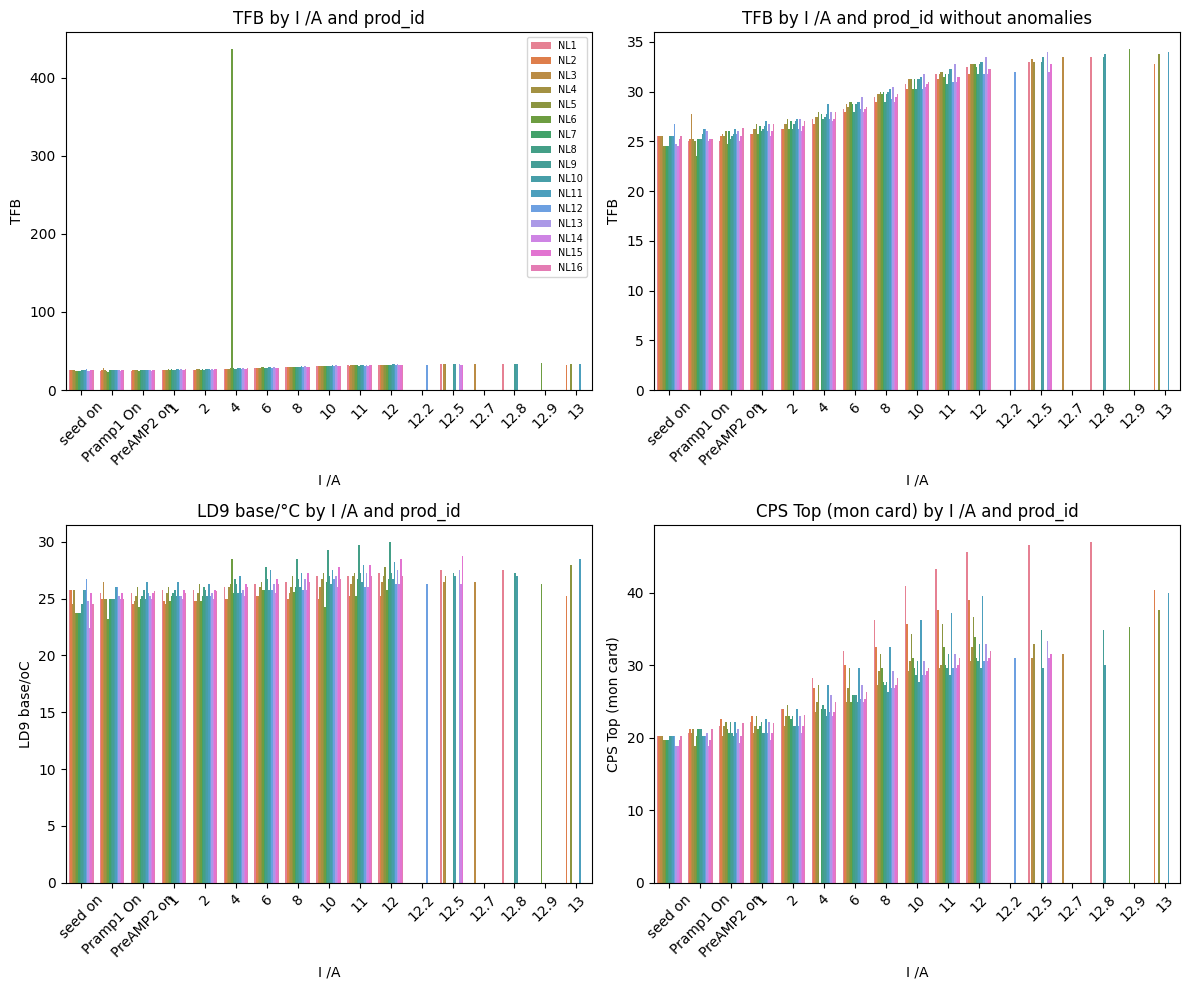

In [31]:
# Ensure the increment of I /A is in ascending order
IA_ordering = ['seed on', 'Pramp1 On', 'PreAMP2 on', 1, 2, 4, 6, 8, 10, 11, 12, 12.2, 12.5, 12.7, 12.8, 12.9, 13]
filled_unit_df['I /A'] = pd.Categorical(filled_unit_df['I /A'], categories=IA_ordering, ordered=True)
filled_unit_df['prod_id'] = pd.Categorical(filled_unit_df['prod_id'], categories=filled_unit_df['prod_id'].unique(), ordered=True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot TFB 
sns.barplot(data=filled_unit_df, x='I /A', y='TFB', hue='prod_id', ax=axes[0, 0])
axes[0, 0].set_title('TFB by I /A and prod_id')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].legend(fontsize='x-small')

# Find the largest TFB value and filter out based on inspection
max_TFB_value = filled_unit_df['TFB'].max()
filtered_df = filled_unit_df[filled_unit_df['TFB'] != max_TFB_value]

# Plot TFB without anomalies
sns.barplot(data=filtered_df, x='I /A', y='TFB', hue='prod_id', ax=axes[0, 1])
axes[0, 1].set_title('TFB by I /A and prod_id without anomalies')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].legend().set_visible(False)

# Plot LD9 base/oC 
sns.barplot(data=filled_unit_df, x='I /A', y='LD9 base/oC', hue='prod_id', ax=axes[1, 0])
axes[1, 0].set_title('LD9 base/°C by I /A and prod_id')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend().set_visible(False)

# Plot CPS Top (mon card
sns.barplot(data=filtered_df, x='I /A', y='CPS Top (mon card)', hue='prod_id', ax=axes[1, 1])
axes[1, 1].set_title('CPS Top (mon card) by I /A and prod_id')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend().set_visible(False)

plt.tight_layout()
plt.show()


**General observations from barplots**

**From the above plots, we can see that temperature of components such as TFB (Tapered Fiber Bundle), LD9 base/oC (Laser Diode 9x Base Temperature in degrees Celsius) and CPS Top (mon card) (Cladding Power Stripper Top on the monitoring card) generally rises as I/A (Current level per ampere) rises.**


### Examining correlation between Current Levels (Excluding Default Settings) with the component temperatures and PD values

In [32]:
# Filter the dataframe
filtered_df = filled_unit_df[~filled_unit_df['I /A'].isin(['seed on', 'Pramp1 On', 'PreAMP2 on'])]

# Calculate correlation and p-value for each pair
corr_IA_TFB, pvalue_IA_TFB = pearsonr(filtered_df['I /A'], filtered_df['TFB'])
corr_IA_LD9, pvalue_IA_LD9 = pearsonr(filtered_df['I /A'], filtered_df['LD9 base/oC'])
corr_IA_CPS, pvalue_IA_CPS = pearsonr(filtered_df['I /A'], filtered_df['CPS Top (mon card)'])
corr_IA_PD1V, pvalue_IA_PD1V = pearsonr(filtered_df['I /A'], filtered_df['PD1/V'])
corr_IA_PD2V, pvalue_IA_PD2V = pearsonr(filtered_df['I /A'], filtered_df['PD2/V'])

# Print the results
def print_results(correlation, pvalue, description):
    print(f"Correlation between I /A and {description}: {correlation}")
    print(f"P-value: {pvalue}")
    print(f"Correlation Statistically Significant: {pvalue < 0.05}")
    print("\n")

print_results(corr_IA_TFB, pvalue_IA_TFB, 'TFB')
print_results(corr_IA_LD9, pvalue_IA_LD9, 'LD9 base/oC')
print_results(corr_IA_CPS, pvalue_IA_CPS, 'CPS Top (mon card)')
print_results(corr_IA_PD1V, pvalue_IA_PD1V, 'PD1/V')
print_results(corr_IA_PD2V, pvalue_IA_PD2V, 'PD2/V')


Correlation between I /A and TFB: 0.00196701198205719
P-value: 0.9812666111000918
Correlation Statistically Significant: False


Correlation between I /A and LD9 base/oC: 0.5748942496713043
P-value: 3.972484989071664e-14
Correlation Statistically Significant: True


Correlation between I /A and CPS Top (mon card): 0.824793219283662
P-value: 3.1364456172161644e-37
Correlation Statistically Significant: True


Correlation between I /A and PD1/V: nan
P-value: nan
Correlation Statistically Significant: False


Correlation between I /A and PD2/V: 0.8371722643171955
P-value: 2.6590380677956688e-39
Correlation Statistically Significant: True




C:\Users\TSiHao\AppData\Local\Temp\ipykernel_22352\646888640.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_IA_PD1V, pvalue_IA_PD1V = pearsonr(filtered_df['I /A'], filtered_df['PD1/V'])


##### Strength of correlation:
- Correlation between I /A and TFB: Very Weak Positive
- Correlation between I /A and LD9 base/oC: Moderate Positive
- Correlation between I /A and CPS Top (mon card): Very Strong Positive
- Correlation between I /A and PD1/V: No Correlation due to identical mean in `PD1/V`
- Correlation between I /A and PD2/V: Very Strong Positive

### Linear Regression of significant correlation pairs to visualise and model relationship

Regression for LD9 base/oC: Intercept: 25.268673096839258, Slope: 0.14737064581014425
Regression for CPS Top (mon card): Intercept: 20.37093073695016, Slope: 1.1224750214438717
Regression for PD2/V: Intercept: -1.2757574607902442, Slope: 0.5127126777377552


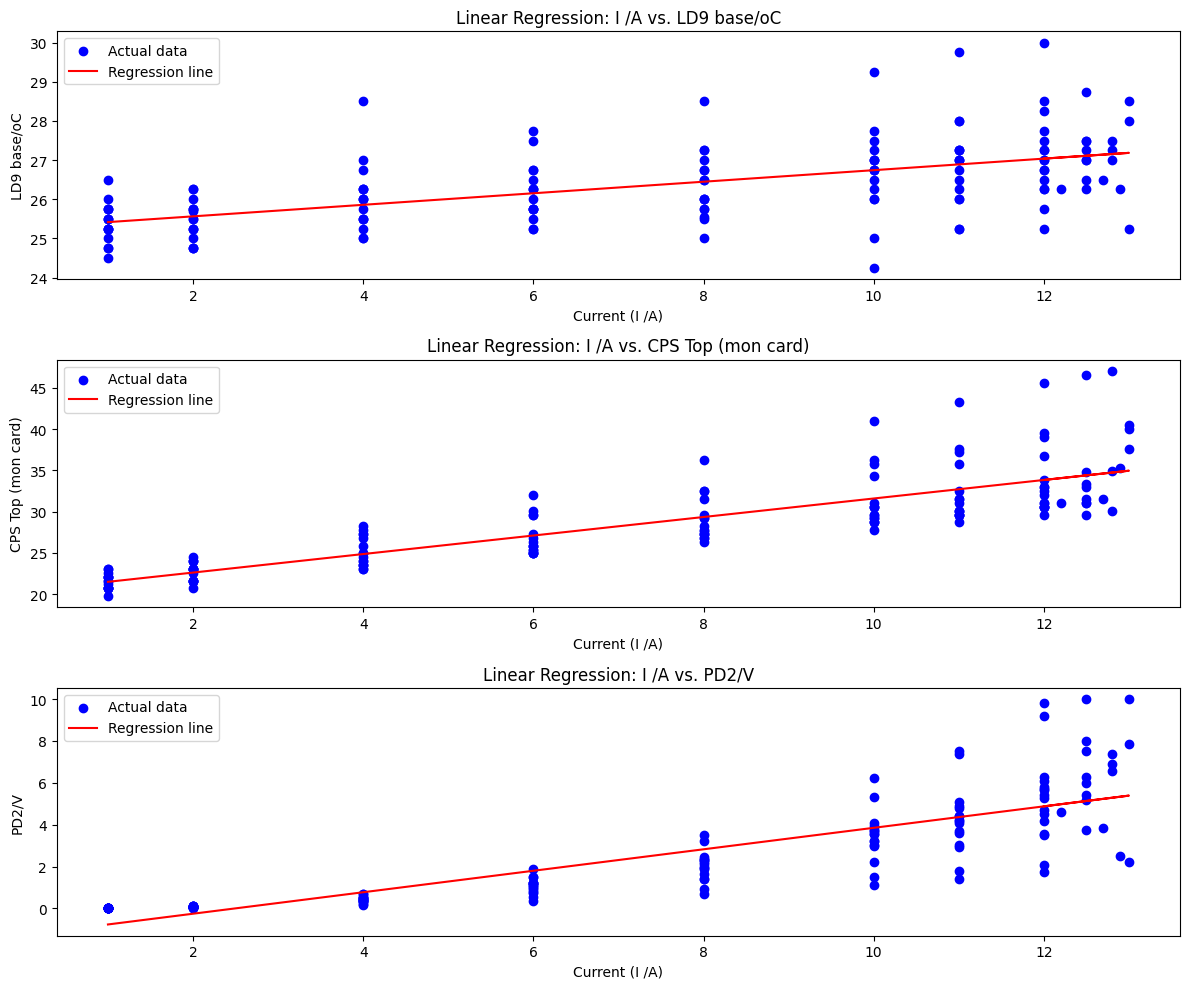

In [33]:
corr_significant_features = ['LD9 base/oC', 'CPS Top (mon card)', 'PD2/V']
X = filtered_df[['I /A']].values

fig, axs = plt.subplots(3, 1, figsize= (12, 10))

for i, feature in enumerate(corr_significant_features):
    y = filtered_df[feature].values

    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    axs[i].scatter(filtered_df['I /A'], y, color='blue', label='Actual data')
    axs[i].plot(filtered_df['I /A'], y_pred, color='red', label='Regression line')
    axs[i].set_xlabel('Current (I /A)')
    axs[i].set_ylabel(feature)
    axs[i].set_title(f'Linear Regression: I /A vs. {feature}')
    axs[i].legend()

    intercept = model.intercept_
    slope = model.coef_[0]
    print(f"Regression for {feature}: Intercept: {intercept}, Slope: {slope}")

plt.tight_layout()
plt.show()

### Finding out the range of temperatures reached by various components of its respective unit

In [34]:
# Recording for each LU, the min to max temperature captured
temp_range_df = filled_unit_df.groupby('prod_id', observed=False)[['TFB', 'LD9 base/oC', 'CPS Top (mon card)']].agg(lambda x: f"{x.min()} to {x.max()}")

print("Range of temperature for each component for each unit during data collection:\n")
print(temp_range_df)

Range of temperature for each component for each unit during data collection:

                    TFB     LD9 base/oC CPS Top (mon card)
prod_id                                                   
NL1        25.0 to 33.5    25.5 to 27.5     20.24 to 47.06
NL2      25.25 to 32.75   24.5 to 25.75     20.24 to 40.47
NL3        25.5 to 33.5    24.5 to 26.5     20.24 to 31.53
NL4       25.25 to 33.0    25.0 to 27.0     20.24 to 32.94
NL5       24.5 to 33.75   23.75 to 28.0     18.82 to 37.65
NL6       23.5 to 436.3   23.25 to 28.5     19.76 to 35.28
NL7        24.5 to 32.5  23.75 to 26.75     19.76 to 31.06
NL8       24.5 to 31.75   23.75 to 30.0     19.76 to 30.59
NL9       25.25 to 33.5   24.5 to 27.25     20.24 to 34.88
NL10      25.5 to 33.75    25.0 to 27.0     20.24 to 30.12
NL11       25.5 to 34.0   25.75 to 28.5      20.24 to 40.0
NL12      25.75 to 32.0  25.25 to 26.75      20.24 to 31.0
NL13      24.75 to 34.0   24.75 to 27.5     18.82 to 33.41
NL14       24.5 to 32.0  22.45 to 26

### Determining what are the max and min temperature at a particular current setting

In [35]:
max_prod_id_TFB = filled_unit_df.loc[filled_unit_df.groupby('I /A', observed=False)['TFB'].idxmax(), ['I /A', 'prod_id', 'TFB']]
min_prod_id_TFB = filled_unit_df.loc[filled_unit_df.groupby('I /A', observed=False)['TFB'].idxmin(), ['I /A', 'prod_id', 'TFB']]

max_prod_id_LD9 = filled_unit_df.loc[filled_unit_df.groupby('I /A', observed=False)['LD9 base/oC'].idxmax(), ['I /A', 'prod_id', 'LD9 base/oC']]
min_prod_id_LD9 = filled_unit_df.loc[filled_unit_df.groupby('I /A', observed=False)['LD9 base/oC'].idxmin(), ['I /A', 'prod_id', 'LD9 base/oC']]

max_prod_id_CPS = filled_unit_df.loc[filled_unit_df.groupby('I /A', observed=False)['CPS Top (mon card)'].idxmax(), ['I /A', 'prod_id', 'CPS Top (mon card)']]
min_prod_id_CPS = filled_unit_df.loc[filled_unit_df.groupby('I /A', observed=False)['CPS Top (mon card)'].idxmin(), ['I /A', 'prod_id', 'CPS Top (mon card)']]

max_min_values_TFB = pd.concat([min_prod_id_TFB.set_index('I /A'), max_prod_id_TFB.set_index('I /A')], axis=1, keys=['Min TFB', 'Max TFB'])
max_min_values_LD9 = pd.concat([min_prod_id_LD9.set_index('I /A'), max_prod_id_LD9.set_index('I /A')], axis=1, keys=['Min LD9 base/oC', 'Max LD9 base/oC'])
max_min_values_CPS = pd.concat([min_prod_id_CPS.set_index('I /A'), max_prod_id_CPS.set_index('I /A')], axis=1, keys=['Min CPS Top (mon card)', 'Max CPS Top (mon card)'])
max_min_values_combined = pd.concat([max_min_values_TFB, max_min_values_LD9, max_min_values_CPS], axis=1)

def highlight_anomaly(val):
    if val == max_TFB_value:
        return 'background-color: orangered' 

max_min_values = max_min_values_combined.style.map(highlight_anomaly)
max_min_values

### Determining which of the units have the largest/least tendency to exhibit extreme temperatures for different components

In [36]:
most_appeared_prod_id_TFB_max = max_min_values_combined['Max TFB']['prod_id'].mode()[0]
most_appeared_prod_id_TFB_min = max_min_values_combined['Min TFB']['prod_id'].mode()[0]
most_appeared_prod_id_LD9_max = max_min_values_combined['Max LD9 base/oC']['prod_id'].mode()[0]
most_appeared_prod_id_LD9_min = max_min_values_combined['Min LD9 base/oC']['prod_id'].mode()[0]
most_appeared_prod_id_CPS_max = max_min_values_combined['Max CPS Top (mon card)']['prod_id'].mode()[0]
most_appeared_prod_id_CPS_min = max_min_values_combined['Min CPS Top (mon card)']['prod_id'].mode()[0]

print("Most Appeared prod_id for Max TFB:", most_appeared_prod_id_TFB_max)
print("Most Appeared prod_id for Min TFB:", most_appeared_prod_id_TFB_min)
print("Most Appeared prod_id for Max LD9 base/oC:", most_appeared_prod_id_LD9_max)
print("Most Appeared prod_id for Min LD9 base/oC:", most_appeared_prod_id_LD9_min)
print("Most Appeared prod_id for Max CPS Top (mon card):", most_appeared_prod_id_CPS_max)
print("Most Appeared prod_id for Min CPS Top (mon card):", most_appeared_prod_id_CPS_min)


Most Appeared prod_id for Max TFB: NL13
Most Appeared prod_id for Min TFB: NL2
Most Appeared prod_id for Max LD9 base/oC: NL8
Most Appeared prod_id for Min LD9 base/oC: NL2
Most Appeared prod_id for Max CPS Top (mon card): NL1
Most Appeared prod_id for Min CPS Top (mon card): NL10


### Timeline to see movement of both Photodiodes' voltage level
- Aim is to see the sensitiveness and rate of increase in voltage level with respect to increase in current

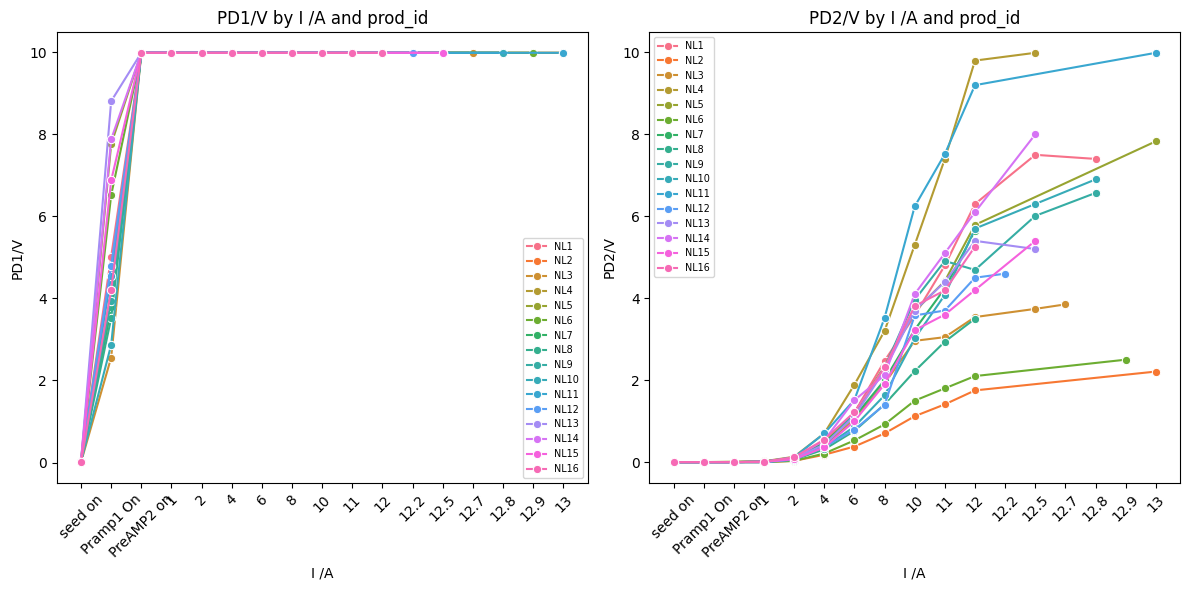

In [37]:
# Define the custom order
filled_unit_df['I /A'] = filled_unit_df['I /A'].astype(str)
IA_ordering = ['seed on', 'Pramp1 On', 'PreAMP2 on', '1', '2', '4', '6', '8', '10', '11', '12', '12.2', '12.5', '12.7', '12.8', '12.9', '13']
filled_unit_df['I /A'] = pd.Categorical(filled_unit_df['I /A'], categories=IA_ordering, ordered=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot PD1/V
sns.lineplot(data=filled_unit_df, x='I /A', y='PD1/V', hue='prod_id', marker='o', ax=axes[0])
axes[0].set_title('PD1/V by I /A and prod_id')
axes[0].set_xlabel('I /A')
axes[0].set_ylabel('PD1/V')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(fontsize='x-small')

# Plot PD2/V
sns.lineplot(data=filled_unit_df, x='I /A', y='PD2/V', hue='prod_id', marker='o', ax=axes[1])
axes[1].set_title('PD2/V by I /A and prod_id')
axes[1].set_xlabel('I /A')
axes[1].set_ylabel('PD2/V')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(fontsize='x-small')

plt.tight_layout()
plt.show()


**General observations from lineplots**

- From the above plots, we can see that across all LUs, PD1 values eventually converges to 9.9v upon Current(I) setting is on `PreAmp2 On`, this indicates that 9.99V is likely the upper limit of the measurement range for PD1, indicating that they have reached saturation.

- As for PD2, overall the voltage levels increases as current level increases. 

- One noticable observation in the PD2 graph is that PD2 values for all LUs were increasing as an increasing rate in the beginning, however beyond 12I/A, we can observe inflection and the rate of increase in voltage significantly slows down(or even decrease for some).





### Finding out the range of voltage reached by photodiodes of each respective unit

In [38]:
# Recording for each LU, the min to max PD values captured
PD_range_df = filled_unit_df.groupby('prod_id', observed=False)[['PD1/V', 'PD2/V']].agg(lambda x: f"{x.min()} to {x.max()}")

print("Range of voltage level for each unit during data collection:\n")
print(PD_range_df)

Range of voltage level for each unit during data collection:

                PD1/V        PD2/V
prod_id                           
NL1      0.02 to 9.99   0.0 to 7.5
NL2      0.02 to 9.99  0.0 to 2.21
NL3      0.01 to 9.99  0.0 to 3.85
NL4      0.02 to 9.99  0.0 to 9.99
NL5      0.03 to 9.99  0.0 to 7.83
NL6      0.03 to 9.99   0.0 to 2.5
NL7      0.03 to 9.99  0.0 to 5.65
NL8      0.03 to 9.99   0.0 to 3.5
NL9      0.01 to 9.99  0.0 to 6.57
NL10     0.02 to 9.99   0.0 to 6.9
NL11     0.02 to 9.99  0.0 to 9.99
NL12     0.04 to 9.99   0.0 to 4.6
NL13     0.03 to 9.99   0.0 to 5.4
NL14     0.04 to 9.99   0.0 to 8.0
NL15     0.02 to 9.99   0.0 to 5.4
NL16     0.01 to 9.99  0.0 to 5.26


- In short, different LUs exhibit varying degrees of photodiode voltage rise for similar load changes, it suggests inconsistencies in LUs performance or differences in design among the units. For eg. **NL4** and **NL11** reaches a maximum voltage output for both of their photodiodes, which may indicate that the LUs' regulation capability is being strained, while units like **NL2** could possibly have better regulation capability shown from its lower rise in voltage output.

### Determining which of the units' 2nd photodiode have the largest/least tendency to exhibit extreme voltage
- 1st photodiode is not meaningful for analysis since all saturated at 9.99v

In [39]:
# Finding out which LU, at a given current setting, exhibited the lowest/highest PD values
max_prod_id_PD2 = filled_unit_df.loc[filled_unit_df.groupby('I /A', observed=False)['PD2/V'].idxmax(), ['I /A', 'prod_id', 'PD2/V']]
min_prod_id_PD2 = filled_unit_df.loc[filled_unit_df.groupby('I /A', observed=False)['PD2/V'].idxmin(), ['I /A', 'prod_id', 'PD2/V']]
max_min_values_PD2 = pd.concat([min_prod_id_PD2.set_index('I /A'), max_prod_id_PD2.set_index('I /A')], axis=1, keys=['Min PD2/V', 'Max PD2/V'])
print(max_min_values_PD2)
most_appeared_prod_id_PD2_max = max_min_values_PD2['Max PD2/V']['prod_id'].mode()[0]
most_appeared_prod_id_PD2_min = max_min_values_PD2['Min PD2/V']['prod_id'].mode()[0]

print("Most Appeared prod_id for Max PD2:", most_appeared_prod_id_PD2_max)
print("Most Appeared prod_id for Min PD2:", most_appeared_prod_id_PD2_min)

           Min PD2/V       Max PD2/V      
             prod_id PD2/V   prod_id PD2/V
I /A                                      
seed on          NL1  0.00       NL1  0.00
Pramp1 On        NL1  0.00       NL1  0.00
PreAMP2 on       NL1  0.00       NL5  0.01
1                NL2  0.00       NL4  0.02
2                NL2  0.03       NL4  0.13
4                NL2  0.18       NL4  0.70
6                NL2  0.38       NL4  1.89
8                NL2  0.70      NL11  3.52
10               NL2  1.12      NL11  6.24
11               NL2  1.41      NL11  7.52
12               NL2  1.75       NL4  9.80
12.2            NL12  4.60      NL12  4.60
12.5             NL3  3.74       NL4  9.99
12.7             NL3  3.85       NL3  3.85
12.8             NL9  6.57       NL1  7.40
12.9             NL6  2.50       NL6  2.50
13               NL2  2.21      NL11  9.99
Most Appeared prod_id for Max PD2: NL4
Most Appeared prod_id for Min PD2: NL2


***

### Inspecting LUs made by NL vs NF
**Part 1. Temperature regulation of components**

In [40]:
NLA_merged_df = pd.merge(unit_info_df, filled_unit_df, how="inner", left_on="Unit", right_on="prod_id")
NLA_merged_df.drop(columns=["Unit"], inplace=True)
NLA_merged_df

,YDF ROC,Vendor,prod_id,I /A,TFB,LD9 base/oC,CPS Top (mon card),PD1/V,PD2/V
0,4.8cm,NL,NL1,seed on,25.50,25.75,20.24,0.02,0.00
1,4.8cm,NL,NL1,Pramp1 On,25.00,25.50,20.71,5.02,0.00
2,4.8cm,NL,NL1,PreAMP2 on,25.00,25.50,21.65,9.99,0.00
3,4.8cm,NL,NL1,1,25.75,25.75,22.12,9.99,0.01
4,4.8cm,NL,NL1,2,26.25,25.75,24.00,9.99,0.09
...,...,...,...,...,...,...,...,...,...
188,4cm,NF,NL16,6,28.50,26.25,26.35,9.99,1.22
189,4cm,NF,NL16,8,29.75,26.50,28.24,9.99,2.31
190,4cm,NF,NL16,10,31.00,26.75,29.65,9.99,3.81
191,4cm,NF,NL16,11,31.50,27.00,31.06,9.99,4.19


### Barplot to show temperature regulation of LUs by different vendors


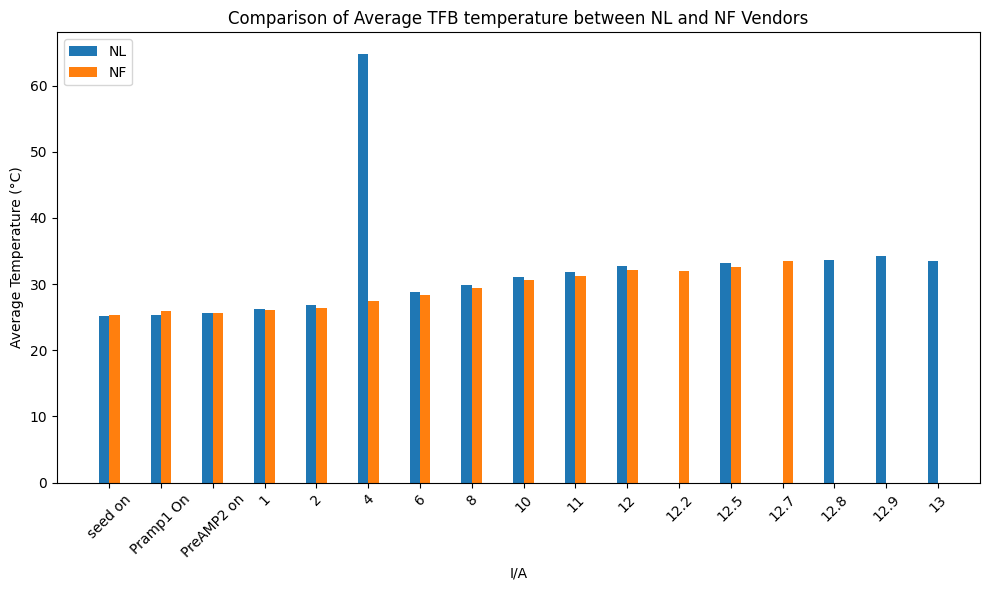

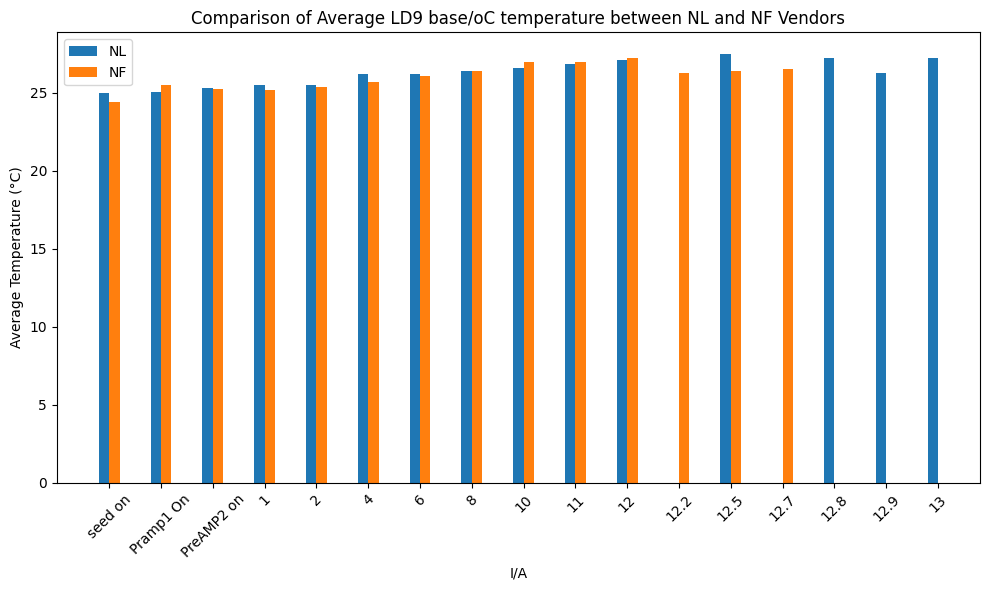

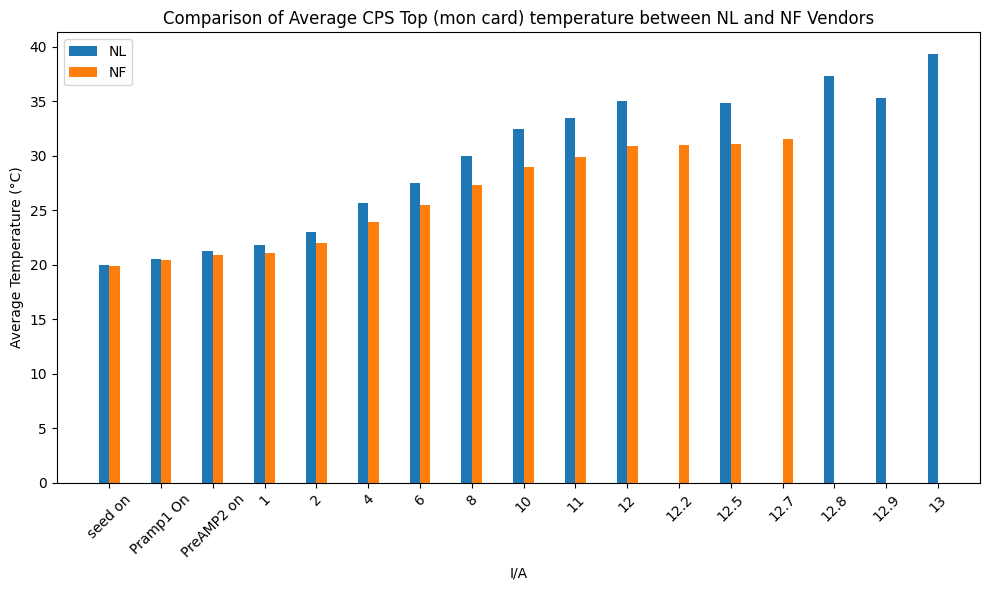

In [41]:
NLA_merged_df[temperature_columns] = NLA_merged_df[temperature_columns].apply(pd.to_numeric, errors="coerce")

nl_data = NLA_merged_df[NLA_merged_df["Vendor"] == "NL"]
nf_data = NLA_merged_df[NLA_merged_df["Vendor"] == "NF"]

nl_avg_temp = nl_data.groupby("I /A", observed=False)[temperature_columns].mean()
nf_avg_temp = nf_data.groupby("I /A", observed=False)[temperature_columns].mean()

for col in temperature_columns:
    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(nl_avg_temp.index))  
    width = 0.2
    ax.bar(x - width/2, nl_avg_temp[col], width, label='NL')
    ax.bar(x + width/2, nf_avg_temp[col], width, label='NF')
    ax.set_xlabel("I/A")
    ax.set_ylabel("Average Temperature (°C)")
    ax.set_title(f"Comparison of Average {col} temperature between NL and NF Vendors")
    ax.set_xticks(x)
    ax.set_xticklabels(nl_avg_temp.index)
    ax.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()



**General observations from barplots grouped by vendors**

From the above plots, we can see that average temperature of components of LUs made by NL are generally higher than those made by NF, indicating that NL's LU components are poorer at managing thermal conditions under different Current settings

- Higher temperatures in NL components might lead to reduced efficiency, increased wear and tear, and potentially shorter lifespan of the LU.
- Higher temperatures in NL components might increase the likelihood of faults or failures, as excessive heat can stress components and lead to premature degradation or malfunction.
- There might be a need to monitor NL LUs more closely to allow early detection of major temperature deviations and prevent faults.




**Part 2. Voltage Output as performance indicator**

High photodiode voltage values might also indicate overdriving or overloading of the photodiode. Overdriving components can lead to accelerated aging, reduced lifespan, or even permanent damage.

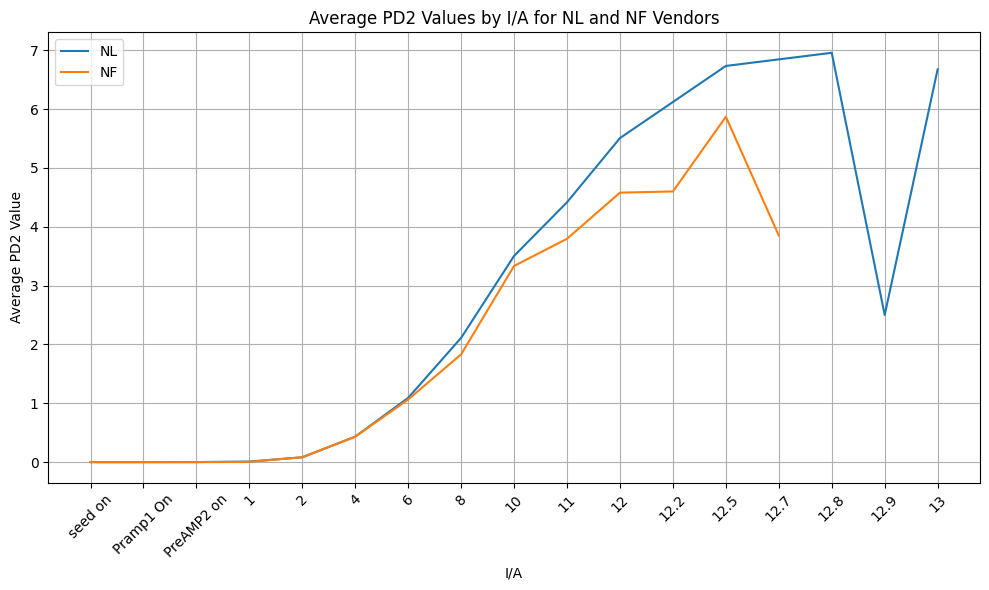

In [42]:
# Group by 'I/A' and calculate mean of 'PD2/V'
nl_avg_pd2 = nl_data.groupby('I /A', observed=False)['PD2/V'].mean().interpolate()
nf_avg_pd2 = nf_data.groupby('I /A', observed=False)['PD2/V'].mean()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(nl_avg_pd2.index, nl_avg_pd2.values, label='NL')
plt.plot(nf_avg_pd2.index, nf_avg_pd2.values, label='NF')

plt.title('Average PD2 Values by I/A for NL and NF Vendors')
plt.xlabel('I/A')
plt.ylabel('Average PD2 Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**General observations from lineplots grouped by vendors**

From the above plots, we can see that average voltage of photodiode 2 of LUs made by NL are again mostly higher than those made by NF

- The voltage level from the photodiode can serve as an indicator of its sensitivity to light, and the higher voltage level from photodiode 2 of LUs made by NL shows that it could be of higher performance as higher voltage levels typically correspond to stronger light signals, while lower voltage levels correspond to weaker signals.

### Pickle dataframes

In [46]:
NLA_merged_df.to_pickle('Created_files/NLA_merged_df.pkl')
unit_info_df.to_pickle('Created_files/unit_info_df.pkl')